Training Conditional GAN...
------------------------------
cGAN Results on Real Cohort
Threshold: 0.2023
AUC:       0.7130
Accuracy:  0.6684
F1 Score:  0.4538
Precision: 0.3176
Recall:    0.7941
------------------------------


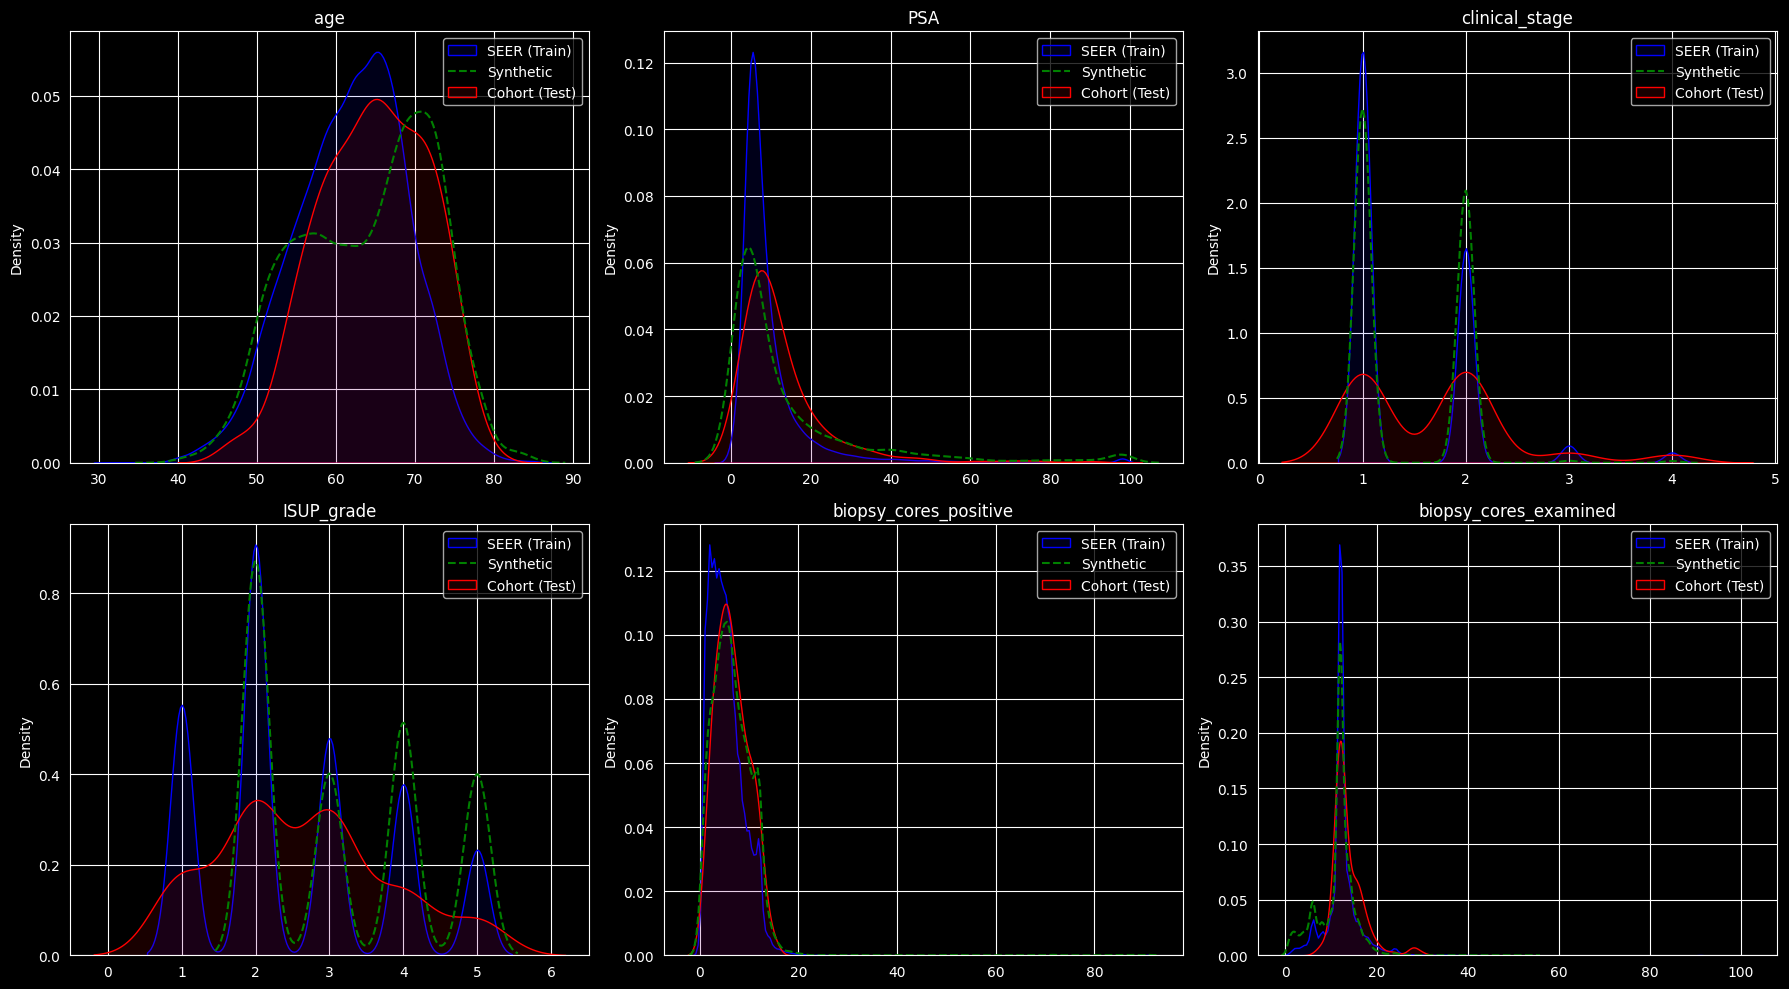

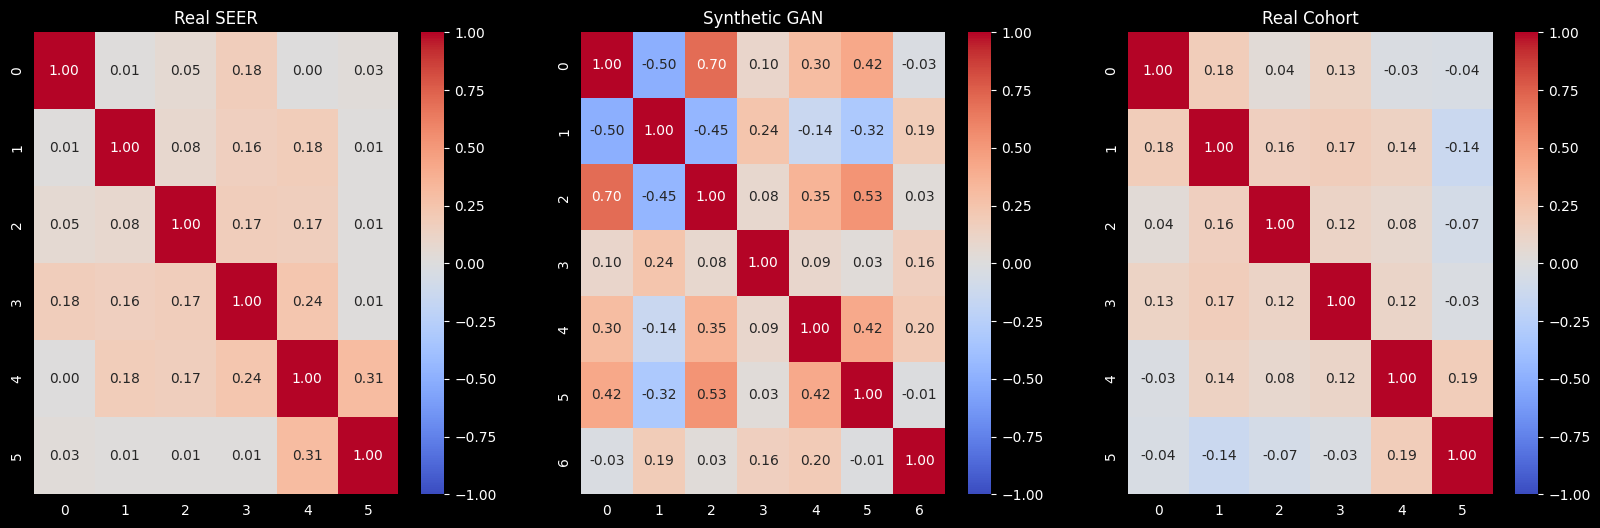

In [2]:
import random
from os import path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.svm import SVC
from torch.utils.data import DataLoader, TensorDataset

SEED = 491
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = "../../data/previous"
seer_path = path.join(data_path, "processed_seer_with_age.csv")
cohort_path = path.join(data_path, "processed_cohort_with_age.csv")

seer = pl.read_csv(seer_path)
cohort = pl.read_csv(cohort_path)

label_col = "target"
int_cols = ["clinical_stage", "ISUP_grade", "biopsy_cores_positive", "biopsy_cores_examined"]
feature_cols = seer.select(pl.exclude(label_col)).columns
int_col_indices = [feature_cols.index(c) for c in int_cols]

X_seer = seer.select(pl.exclude(label_col)).to_numpy().astype(np.float32)
y_seer = seer.get_column(label_col).to_numpy().astype(np.int64)
X_cohort = cohort.select(pl.exclude(label_col)).to_numpy().astype(np.float32)
y_cohort = cohort.get_column(label_col).to_numpy().astype(np.int64)

qt = QuantileTransformer(output_distribution="normal", random_state=SEED)
X_seer_norm = qt.fit_transform(X_seer).astype(np.float32)

dataset = TensorDataset(
    torch.from_numpy(X_seer_norm).to(device),
    torch.from_numpy(y_seer).to(device)
)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True)


class Generator(nn.Module):
    def __init__(self, z_dim, feature_dim, label_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim + label_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, feature_dim)
        )
        self.label_emb = nn.Embedding(label_dim, label_dim)

    def forward(self, z, labels):
        c = self.label_emb(labels)
        x = torch.cat([z, c], dim=1)
        return self.net(x)


class Discriminator(nn.Module):
    def __init__(self, feature_dim, label_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(feature_dim + label_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        self.label_emb = nn.Embedding(label_dim, label_dim)

    def forward(self, x, labels):
        c = self.label_emb(labels)
        x = torch.cat([x, c], dim=1)
        return self.net(x)


z_dim = 64
feature_dim = X_seer_norm.shape[1]
netG = Generator(z_dim, feature_dim).to(device)
netD = Discriminator(feature_dim).to(device)
optG = optim.Adam(netG.parameters(), lr=2e-4, betas=(0.5, 0.999))
optD = optim.Adam(netD.parameters(), lr=2e-4, betas=(0.5, 0.999))
criterion = nn.BCELoss()

print("Training Conditional GAN...")
for epoch in range(150):
    for real_x, real_y in dataloader:
        batch_size = real_x.size(0)

        # Train D
        netD.zero_grad()
        real_labels = torch.full((batch_size, 1), 0.9, device=device)
        output_real = netD(real_x, real_y)
        loss_d_real = criterion(output_real, real_labels)

        noise = torch.randn(batch_size, z_dim, device=device)
        fake_labels = torch.randint(0, 2, (batch_size,), device=device)
        fake_x = netG(noise, fake_labels)
        fake_targets = torch.zeros((batch_size, 1), device=device)
        output_fake = netD(fake_x.detach(), fake_labels)
        loss_d_fake = criterion(output_fake, fake_targets)

        loss_d = loss_d_real + loss_d_fake
        loss_d.backward()
        optD.step()

        # Train G
        netG.zero_grad()
        valid_targets = torch.ones((batch_size, 1), device=device)
        output_gen = netD(fake_x, fake_labels)
        loss_g = criterion(output_gen, valid_targets)
        loss_g.backward()
        optG.step()

n_syn = 10000
cohort_prevalence = np.mean(y_cohort)
n_pos = int(n_syn * cohort_prevalence)
n_neg = n_syn - n_pos

syn_labels = torch.cat([torch.zeros(n_neg), torch.ones(n_pos)]).long().to(device)
syn_labels = syn_labels[torch.randperm(n_syn)]

netG.eval()
with torch.no_grad():
    noise = torch.randn(n_syn, z_dim, device=device)
    syn_x_raw = netG(noise, syn_labels).cpu().numpy()

X_syn_raw = qt.inverse_transform(syn_x_raw)
for idx in int_col_indices:
    X_syn_raw[:, idx] = np.round(X_syn_raw[:, idx])
    if feature_cols[idx] == "ISUP_grade":
        X_syn_raw[:, idx] = np.clip(X_syn_raw[:, idx], 1, 5)

syn_df = pl.DataFrame(X_syn_raw, schema=feature_cols).with_columns(pl.Series(label_col, syn_labels.cpu().numpy()))

scaler = StandardScaler()
X_train = scaler.fit_transform(syn_df.select(pl.exclude(label_col)).to_numpy())
y_train = syn_df.get_column(label_col).to_numpy()
X_test = scaler.transform(X_cohort)

svm = SVC(probability=True, class_weight='balanced', random_state=SEED)
svm.fit(X_train, y_train)
y_prob = svm.predict_proba(X_test)[:, 1]

p, r, t = precision_recall_curve(y_cohort, y_prob)
f1_scores = (2 * p * r) / (p + r + 1e-8)
best_thresh = t[np.argmax(f1_scores[:-1])]
y_pred = (y_prob >= best_thresh).astype(int)

print("-" * 30)
print(f"cGAN Results on Real Cohort")
print(f"Threshold: {best_thresh:.4f}")
print(f"AUC:       {roc_auc_score(y_cohort, y_prob):.4f}")
print(f"Accuracy:  {accuracy_score(y_cohort, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_cohort, y_pred):.4f}")
print(f"Precision: {precision_score(y_cohort, y_pred):.4f}")
print(f"Recall:    {recall_score(y_cohort, y_pred):.4f}")
print("-" * 30)

real_seer_df = pl.DataFrame(X_seer, schema=feature_cols)
real_cohort_df = pl.DataFrame(X_cohort, schema=feature_cols)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, col in enumerate(feature_cols):
    sns.kdeplot(real_seer_df[col], ax=axes[i], color='blue', label='SEER (Train)', fill=True, alpha=0.1)
    sns.kdeplot(syn_df[col], ax=axes[i], color='green', label='Synthetic', linestyle='--')
    sns.kdeplot(real_cohort_df[col], ax=axes[i], color='red', label='Cohort (Test)', fill=True, alpha=0.1)
    axes[i].set_title(col)
    axes[i].legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
sns.heatmap(real_seer_df.corr(), annot=True, fmt=".2f", ax=ax[0], cmap='coolwarm', vmin=-1, vmax=1)
ax[0].set_title("Real SEER")
sns.heatmap(syn_df.corr(), annot=True, fmt=".2f", ax=ax[1], cmap='coolwarm', vmin=-1, vmax=1)
ax[1].set_title("Synthetic GAN")
sns.heatmap(real_cohort_df.corr(), annot=True, fmt=".2f", ax=ax[2], cmap='coolwarm', vmin=-1, vmax=1)
ax[2].set_title("Real Cohort")
plt.show()

### Interpretation of Conditional GAN Results

Conditional GAN (cGAN) struggled more than the Diffusion model in capturing the nuances of the tabular data. While the cGAN achieved reasonable sensitivity (**Recall: ~0.79**), it had a harder time stabilizing the feature correlations. As shown in the correlation heatmaps , the "Synthetic GAN" correlations (center plot) show some noisy or inverse relationships (blue squares) that do not exist in the real SEER or Cohort data.

This "noisier" generation led to a lower **AUC (0.71)** compared to the Diffusion model (0.81). The GAN correctly identified the general trend that higher-stage patients are higher risk (hence the decent Recall), but its lack of precision in modeling the joint distributions resulted in even lower **Precision (0.32)** and **F1 (0.45)**. This suggests that for this specific dataset with mixed discrete and continuous variables, the Diffusion model's stable, iterative refinement process is superior to the competitive training process of the GAN.